<a href="https://colab.research.google.com/github/anindabitm/Zindi_hack/blob/master/Zindi-hack-4-nlp-vaccine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Zindi hack 4 - To Vaccinate or Not to Vaccinate: It’s not a Question by #ZindiWeekendz

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import os
import random
import torch
os.chdir('/content/drive/My Drive/Zindi_Hack/4')

In [0]:
!ls

df_train.csv  models  SampleSubmission.csv  Test.csv  Train.csv


In [0]:
SEED=42
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [0]:
train=pd.read_csv('Train.csv')
print('The shape of train file is:',train.shape)
train.head(5)

The shape of train file is: (10001, 4)


,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [0]:
print('The NaN values are:',train.isna().sum())
train.dropna(inplace=True)

The NaN values are: tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64


In [0]:
test=pd.read_csv('Test.csv')
print('The shape of test file is:',test.shape)
test.head(5)

The shape of test file is: (5177, 2)


,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [0]:
test.isna().sum()
test.fillna('Nothing',inplace=True)

In [0]:
train.dtypes

tweet_id      object
safe_text     object
label        float64
agreement    float64
dtype: object

In [0]:
data=pd.DataFrame(pd.concat([train['safe_text'],test['safe_text']],ignore_index=True))
print('The shape of data file is:',data.shape)
data.head(5)

The shape of data file is: (15176, 1)


,safe_text
0,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1,I'm 100% thinking of devoting my career to pro...
2,"#whatcausesautism VACCINES, DO NOT VACCINATE Y..."
3,I mean if they immunize my kid with something ...
4,Thanks to <user> Catch me performing at La Nui...


In [0]:
from fastai.text import *

In [0]:
cols=['safe_text']
data_bunch = (TextList.from_df(data, cols=cols)
                .split_by_rand_pct(0.2,seed=SEED)
                .label_for_lm()  
                .databunch(bs=48)
             )
data_bunch.show_batch()

idx,text
0,"# xxunk xxup vaccines , xxup do xxup not xxup vaccinate xxup your xxup child xxbos xxmaj thanks to < user > xxmaj catch me performing at xxmaj la xxmaj xxunk xxup nyc xxunk 1st ave . xxmaj show starts at 6 ! # jennifair # mmr … < url > xxbos < user > a nearly xxunk year old study when mental health studies and vaccines were xxunk in"
1,"user > < user > xxrep 8 a nd that 's why they 're not called autism vaccines xxbos 7 more flu deaths in xxmaj xxunk xxunk \n xxmaj vaccines = easy 2 get & & free 4 those in $ $ $ xxunk \n xxmaj xxunk > > # xxmaj obamacare , xxup chip , xxmaj medicaid & & xxmaj medicare \n < user > xxbos"
2,"the other comment , xxmaj vaccines do not require live virus . xxbos xxup u.s. xxmaj measles xxmaj cases xxmaj hit 20-year xxmaj high < url > xxbos i am going to xxunk xxmaj news : xxmaj ebola is entering the xxup u.s. via xxmaj muslim xxunk babies and xxmaj obama spent vaccine research $ $ $ on golf ... xxbos xxmaj frisco xxup isd to xxmaj offer xxmaj back"
3,"… < url > xxbos < user > xxunk xxunk xxunk measles mumps rubella vaccine . xxmaj xxunk xxbos "" xxmaj tom xxmaj brady , you just won the xxmaj super xxmaj bowl . xxmaj what are you going to do now ? "" \n xxmaj brady : "" xxmaj sure as hell not going to xxmaj disneyland and get the measles ! "" xxbos xxmaj health fair kicks"
4,"xxrep 4 ! :) xxbos “ < user > xxmaj open letter from a xxmaj xxunk to her daughters regarding # xxmaj gardasil # xxup hpv # vaccine # health < url > < user > xxbos xxmaj what 's in your # flushot ? xxmaj if you knew , you probably would n't get one ! # vaccine # vaccines # health # sick < user > < url"


In [0]:
learn_lm = language_model_learner(data_bunch,AWD_LSTM,pretrained=True,drop_mult=0.7)

In [0]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


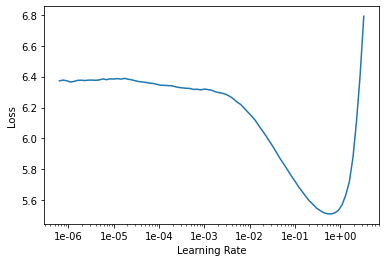

In [0]:
learn_lm.recorder.plot()

In [0]:
learn_lm.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.514557,4.654013,0.231312,00:10
1,4.733943,4.270078,0.259747,00:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


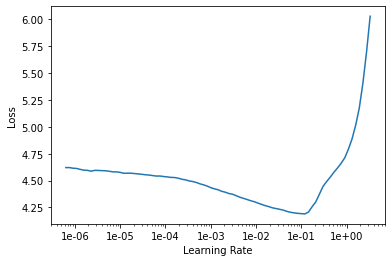

In [0]:
# Unfreeze and find learning rate
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot()

In [0]:
learn_lm.fit_one_cycle(10, 1e-3,moms=(0.7,0.8))

# Save the encoder for use in classification
learn_lm.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,3.577836,3.392752,0.372644,00:10
1,3.485837,3.284600,0.388653,00:10
2,3.348818,3.182169,0.399628,00:11
3,3.174054,3.110574,0.408457,00:10
4,3.038285,3.073508,0.413777,00:10
5,2.900102,3.053642,0.418006,00:10
6,2.792555,3.047413,0.418663,00:10
7,2.711298,3.044597,0.420809,00:10
8,2.661150,3.044212,0.421404,00:10
9,2.624064,3.044924,0.421354,00:10


In [0]:
pd.crosstab(train['label'],train['agreement'])

agreement,0.333333,0.666667,1.000000
label,,,
-1.0,239,417,382
0.0,0,1748,3160
1.0,0,1729,2324


In [0]:
train['sentiment']=train['label']*train['agreement']
train.head()

,tweet_id,safe_text,label,agreement,sentiment
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0,0.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0,-1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,-1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0,0.0


In [0]:
train.dtypes

tweet_id      object
safe_text     object
label        float64
agreement    float64
sentiment    float64
dtype: object

In [0]:
df=train.copy()

In [0]:
target_cols=['sentiment']
def databunch_func(train_index,test_index):
  df_train=df.iloc[train_index,:]
  df_val=df.iloc[test_index,]
  data_clas = TextClasDataBunch.from_df('.', df_train, df_val, test,
                  vocab=data_bunch.vocab,
                  text_cols=cols,
                  label_cols=target_cols,
                  bs=32)
  return data_clas

In [0]:
sub=pd.read_csv('SampleSubmission.csv')
sub.shape

(5177, 2)

In [0]:
#Creating cross-validation framework
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=SEED)
X=train['safe_text'].copy()
y=train['sentiment'].copy()
fold = 0
final_preds=np.zeros((sub.shape[0],sub.shape[1]))
for train_index, test_index in kf.split(X, y):
  fold+= 1
  print('*******************************IN FOLD:  ',fold,'**************************************************')
  data_clas=databunch_func(train_index,test_index)
  learn_classifier = text_classifier_learner(data_clas, AWD_LSTM,pretrained=True,drop_mult=0.7,metrics=[root_mean_squared_error])
  final_preds1=np.zeros((sub.shape[0],sub.shape[1]))
  # load the encoder saved  
  learn_classifier.load_encoder('fine_tuned_enc')
  learn_classifier.freeze()
  learn_classifier.fit_one_cycle(5, 1e-6, moms=(0.8,0.7))
  learn_classifier.freeze_to(-2)
  learn_classifier.fit_one_cycle(5, 1e-2,moms=(0.8,0.7))
  learn_classifier.unfreeze()
  learn_classifier.fit_one_cycle(5, 1e-5)
  preds_test, _ = learn_classifier.get_preds(DatasetType.Test, ordered=True)
  print('PREDICTION COMPLETED IN FOLD: {}'.format(str(fold)))
  final_preds+=preds_test.numpy()

final_preds=final_preds/5

*******************************IN FOLD:   1 **************************************************


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.644190,0.591075,0.763537,00:32
1,0.621714,0.546560,0.733878,00:32
2,0.623510,0.539104,0.728895,00:31
3,0.611992,0.585041,0.758785,00:30
4,0.602713,0.561446,0.743308,00:31


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.268293,0.282410,0.527365,00:32
1,0.245743,0.261020,0.505173,00:31
2,0.232100,0.264923,0.509463,00:33
3,0.202881,0.240585,0.485238,00:31
4,0.184885,0.241115,0.485463,00:31


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.170825,0.239743,0.484162,00:33
1,0.175180,0.242193,0.486645,00:35
2,0.172947,0.240952,0.485297,00:36
3,0.173271,0.240573,0.484843,00:33
4,0.170574,0.237194,0.481767,00:36


PREDICTION COMPLETED IN FOLD: 1
*******************************IN FOLD:   2 **************************************************


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.716786,0.578819,0.755672,00:31
1,0.698570,0.501471,0.703680,00:33
2,0.653333,0.509385,0.709074,00:32
3,0.680060,0.486654,0.692950,00:33
4,0.639318,0.492971,0.697517,00:32


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.274838,0.245270,0.489923,00:32
1,0.253849,0.232612,0.476652,00:31
2,0.236683,0.235101,0.479613,00:31
3,0.213124,0.214447,0.455257,00:33
4,0.188972,0.202761,0.442851,00:31


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.182828,0.201977,0.441697,00:33
1,0.189154,0.202682,0.442419,00:34
2,0.179509,0.206162,0.446255,00:36
3,0.187214,0.201341,0.441115,00:36
4,0.179835,0.205621,0.445694,00:34


PREDICTION COMPLETED IN FOLD: 2
*******************************IN FOLD:   3 **************************************************


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.732819,0.588716,0.761039,00:31
1,0.723447,0.565530,0.745575,00:33
2,0.676755,0.551936,0.735607,00:32
3,0.692241,0.520982,0.715880,00:33
4,0.717366,0.542548,0.729176,00:32


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.271354,0.284958,0.526977,00:32
1,0.252438,0.248160,0.493449,00:30
2,0.248791,0.221665,0.464580,00:31
3,0.221622,0.213226,0.455062,00:33
4,0.192130,0.217328,0.459399,00:31


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.192252,0.210428,0.452240,00:33
1,0.191251,0.213696,0.455525,00:34
2,0.184794,0.209928,0.451607,00:36
3,0.180002,0.208477,0.450164,00:36
4,0.186618,0.210139,0.451727,00:34


PREDICTION COMPLETED IN FOLD: 3
*******************************IN FOLD:   4 **************************************************


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.708014,0.534438,0.727140,00:31
1,0.704318,0.521159,0.717964,00:33
2,0.681839,0.534077,0.726713,00:32
3,0.657011,0.510153,0.710060,00:33
4,0.641018,0.517360,0.715073,00:32


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.276209,0.275027,0.520212,00:32
1,0.247851,0.238034,0.481986,00:30
2,0.249471,0.238922,0.483619,00:31
3,0.219674,0.220692,0.464690,00:33
4,0.190228,0.212573,0.456033,00:31


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.191454,0.210336,0.453878,00:33
1,0.187011,0.209650,0.453061,00:34
2,0.181784,0.211925,0.455400,00:36
3,0.178113,0.215112,0.458772,00:35
4,0.190955,0.214262,0.457852,00:34


PREDICTION COMPLETED IN FOLD: 4
*******************************IN FOLD:   5 **************************************************


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.702352,0.582597,0.756931,00:30
1,0.704756,0.551487,0.736172,00:30
2,0.674205,0.565340,0.745663,00:30
3,0.694643,0.536806,0.726265,00:30
4,0.688552,0.545769,0.732329,00:30


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.278333,0.238403,0.483188,00:30
1,0.253651,0.238418,0.482223,00:30
2,0.243753,0.223542,0.466699,00:30
3,0.220206,0.212356,0.454933,00:30
4,0.186212,0.216409,0.459330,00:30


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.190181,0.213454,0.456226,00:32
1,0.180314,0.211191,0.453473,00:32
2,0.186959,0.218030,0.461206,00:33
3,0.178996,0.216986,0.459778,00:32
4,0.177833,0.214625,0.457588,00:32


PREDICTION COMPLETED IN FOLD: 5


In [0]:
sub['label']=final_preds
sub.head()

,tweet_id,label
0,00BHHHP1,0.041357
1,00UNMD0E,0.517521
2,01AXPTJF,0.237487
3,01HOEQJW,0.835241
4,01JUKMAO,0.235118


In [0]:
sub.to_csv('submission_fastai_reg_cv.csv',index=False)